# BatchNorm as a Regulariser
 - BN does a couple of things: 
    - Allows for deep gradient propagation by ensuring inputs are of similar magnitudes for all layers
    - This has the effect of smoothing the loss surface -> speeding up training and making it more robust
    - Affine transformation of entire channels, which can have downstream applications (e.g channel pruning)
    - Injecting noise in layer inputs via the normalisation of a random batch
- Noise injection is the main reason why BN behaves as a regulariser
    - However, note that just reducing batch-size (wihout BN) has also a reg effect via SGD
- Noise injection acts as data augmentation by creating new samples close to their original location
- The amount (magnitude) of injected noise is goverened by the batch size
    - The smaller it is the more variance statistics will have 
    - This results in samples being displaced farther away
- Intutively we can think of adding noise as blurring decision boundaries
    - If classes are easily separatable then adding noise to datapoints on the margin will not make a difference
    - If the margin between classes was messy to begin with (overlapping), adding noise will make it even harder to learn 
    - Ensures that the model does not overfit by learning every datapoint on the margin by heart
    - Effect is a smoother decision boundary
- By artificially increasing the dataset difficulty we effectively reduce excess model capacity, which forces a model to draw simple decision boundaries
- In this notebook we quantify the amount of regularisation via 2D toy problems
- We create several datasets with increasing difficulty and see how classification performance changes for various model capacities and batch sizes
- We confirm that neural nets can learn any random data, and thus overfit very easily if they have capacity
- We observe that small batch sizes will stop the model from overfitting, and maintain is best possible performance
    - Note: by construction in this particular case we cannot over-regularise
- Note: if a dataset is difficult then regularising the model will not magically make it better than what it is possible to learn for its inductive bias
    - The toy data is noise, we know there is nothing more meaningful a model can learn if it has access to more capacity
    - The best performance we can get is that of the "right" model within it's class (where capacity meets problem complexity)
    - We just ensure that even if we pick the wrong model we still get the performance of the "right" one

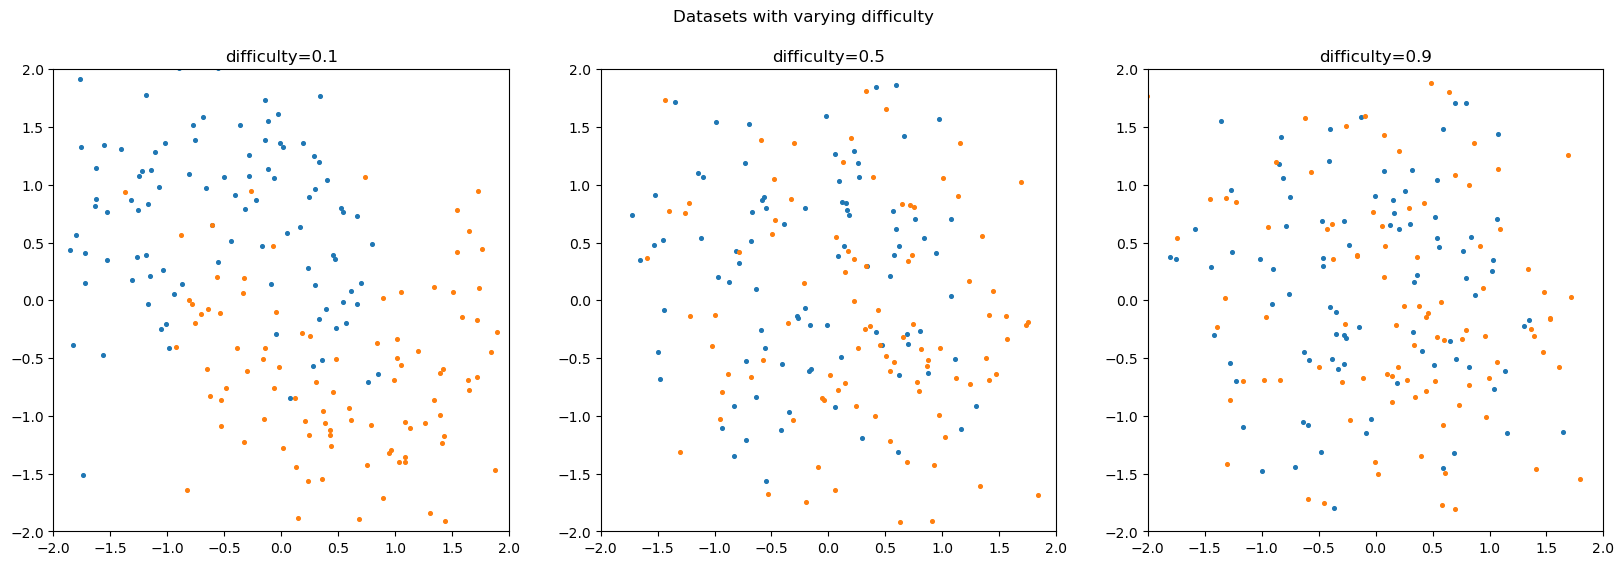

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


def get_data(n_samples=200, difficulty=0.1):
    assert 0 <= difficulty <= 1, "difficulty must be in [0, 1]"
    difficulty = difficulty * 3
    X, y = make_moons(n_samples=n_samples, noise=difficulty, random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

def plot_data(X, y, ax=None, title="", alpha=1):
    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], s=7, alpha=alpha)
    ax.scatter(X[:,0][y==1], X[:,1][y==1], s=7, alpha=alpha)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_title(title)

fig, axarr = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Datasets with varying difficulty")
plot_data(*get_data(difficulty=0.1), ax=axarr[0], title="difficulty=0.1")
plot_data(*get_data(difficulty=0.5), ax=axarr[1], title="difficulty=0.5")
plot_data(*get_data(difficulty=0.9), ax=axarr[2], title="difficulty=0.9")

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


def get_dataset(n_samples=1000, difficulty=0.0, split=0.5):
    X, y = get_data(n_samples=n_samples, difficulty=difficulty)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=split, random_state=0
    )
    X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
    y_train = torch.tensor(y_train, dtype=torch.long).cuda()
    X_val = torch.tensor(X_val, dtype=torch.float32).cuda()
    y_val = torch.tensor(y_val, dtype=torch.long).cuda()
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    return train_ds, val_ds


def plot_decision_boundary(model, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()

    model.eval().cpu()
    Z = model(grid).softmax(axis=1)[:, 0].detach().numpy()
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)


def init_model(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

In [30]:
def trainer(arch="3/10", batch_size=32, difficulty=0.0, bn=True, plot=False, ax=None) -> float:
    # Data
    train_ds, val_ds = get_dataset(n_samples=1000, difficulty=difficulty)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Model
    depth, width = [int(x) for x in arch.split("/")]
    layers = []
    for depth_ in range(depth):
        layers.append(nn.Linear(2 if depth_ == 0 else width, width))
        if bn:
            layers.append(nn.BatchNorm1d(width))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(width, 2))
    model = nn.Sequential(*layers).cuda()
    init_model(model)

    # Optim
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=1e-2)

    # Train
    for epoch in range(100):
        for batch_X, batch_y in train_loader:
            optimiser.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimiser.step()

    # Evaluate
    accuracy = Accuracy(task="multiclass", num_classes=2).cuda()
    with torch.no_grad():
        model.eval()
        outputs = model(val_ds.tensors[0])
        acc = accuracy(outputs, val_ds.tensors[1]).item()

    if plot:
        plot_decision_boundary(model, ax)
    return acc

# Decision Boundary
- Qualitative examples of batch-size effect on decision boundary
- Regularisation effect is high when batch-size is small and vice versa
- Overfitting occurs only for models with capacity larger than problem complexity

### Capacity and Overfitting
- Models with low capacity don't overfit regardless of regularisation strength (batch size)
- Due to the construction of the problem we don't really see performance degradation due to over-regularisation
- BN and batch-size stop model with high capacity from overfitting

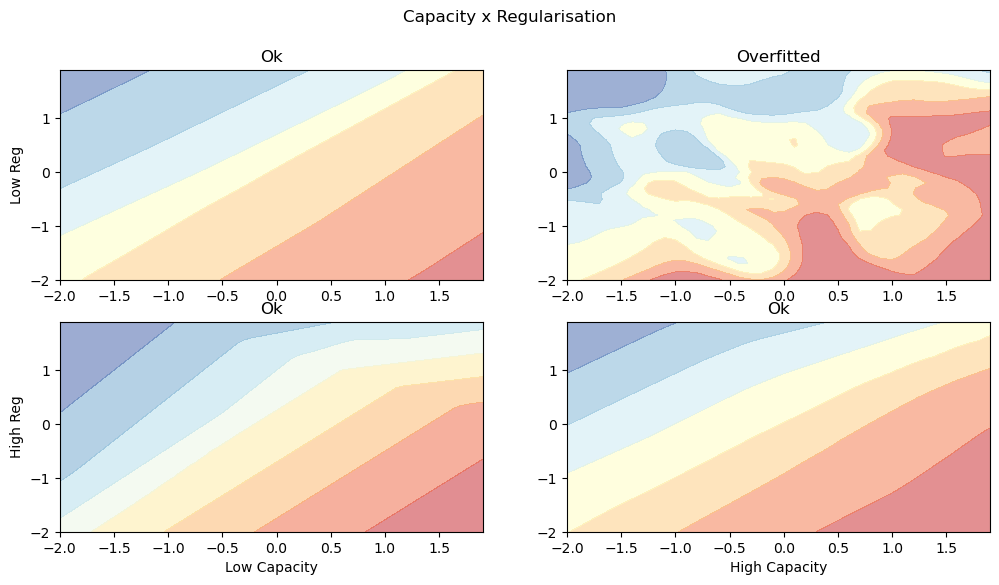

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("Capacity x Regularisation")

axes[0, 0].set_ylabel("Low Reg")
axes[1, 0].set_ylabel("High Reg")
axes[1, 0].set_xlabel("Low Capacity")
axes[1, 1].set_xlabel("High Capacity")

axes[0, 0].set_title("Ok")
trainer(arch="1/5", batch_size=100, difficulty=0.5, plot=True, ax=axes[0,0])

axes[0, 1].set_title("Overfitted")
trainer(arch="5/30", batch_size=100, difficulty=0.5, plot=True, ax=axes[0,1])

axes[1, 0].set_title("Ok")
trainer(arch="1/5", batch_size=10, difficulty=0.5, plot=True, ax=axes[1,0])

axes[1, 1].set_title("Ok")
trainer(arch="5/30", batch_size=10, difficulty=0.5, plot=True, ax=axes[1,1])

plt.show()

### Batchsize without BN
- Question is whether reg effect is caused by SGD and not BN necessarily
- See reg effects of larger model for high and low batch sizes
- Technically for a fair comparison I should normalise activations based on population stats but that's an overkill
- Small batch-size with only SGD has a positive effect, so some regularisation can be attributed to that
    - A more rigurous analysis would probably show that it is an effective regulariser in itself

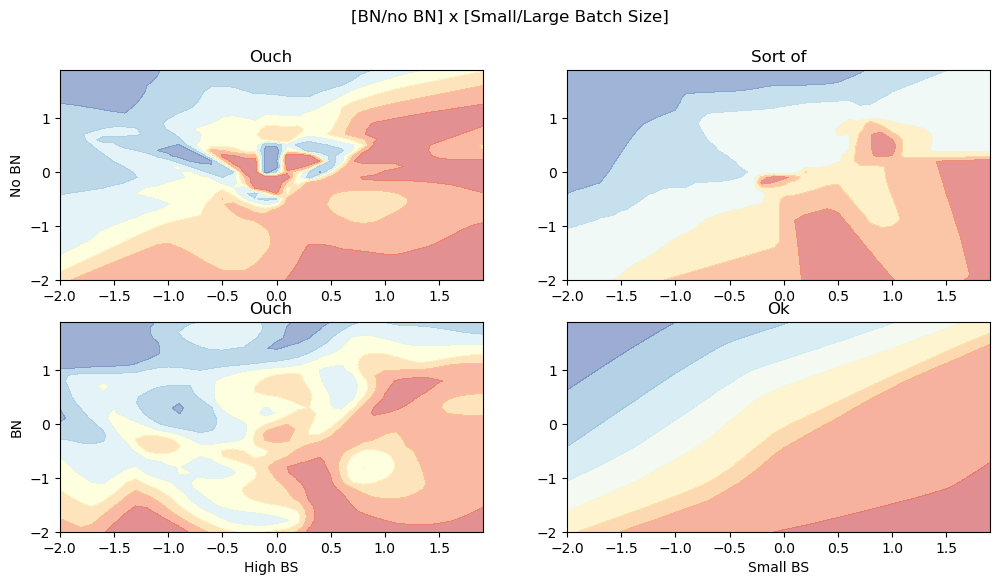

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("[BN/no BN] x [Small/Large Batch Size]")

axes[0, 0].set_ylabel("No BN")
axes[1, 0].set_ylabel("BN")
axes[1, 0].set_xlabel("High BS")
axes[1, 1].set_xlabel("Small BS")

axes[0, 0].set_title("Ouch")
trainer(arch="5/30", batch_size=100, bn=False, difficulty=0.5, plot=True, ax=axes[0,0])

axes[0, 1].set_title("Sort of")
trainer(arch="5/30", batch_size=10, bn=False, difficulty=0.5, plot=True, ax=axes[0,1])

axes[1, 0].set_title("Ouch")
trainer(arch="5/30", batch_size=100, bn=True, difficulty=0.5, plot=True, ax=axes[1,0])

axes[1, 1].set_title("Ok")
trainer(arch="5/30", batch_size=10, bn=True, difficulty=0.5, plot=True, ax=axes[1,1])

plt.show()

# Benchmarks

### Setup
- Evaluating acc on noisy validation set
- Plotting how performance drops as dataset difficulty increases (x-axis)
- See performance curve of different model capacities (colours)
- "3/10" is a netowrk with 3 layers each 10 neuron wide
- Plot behaviour for different regularisation strengths (batch size)
- Dataset itself is "unsolvable" by design so more capacity cannot improve performance

### Results
- Dataset is very simple so the smallest architecture will perform best
- As we increase capacity all models start to overfit
- The more difficult the dataset the larger the drop relative to the smallest arch
- Reducing batch size successfully mitigates overfitting
- Regularised models perform the same as the "best" arch regardless of capacity


In [24]:
res = []
for difficulty in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for arch in ["1/5", "3/10", "5/20", "7/30"]:
        for batch_size in [10, 20, 100]:
            acc = np.mean([trainer(arch=arch, batch_size=batch_size, difficulty=difficulty) for _ in range(3)])
            res.append({
                "difficulty": difficulty,
                "arch": arch,
                "batch_size": batch_size,
                "acc": acc,
            })
res = pd.DataFrame(res)

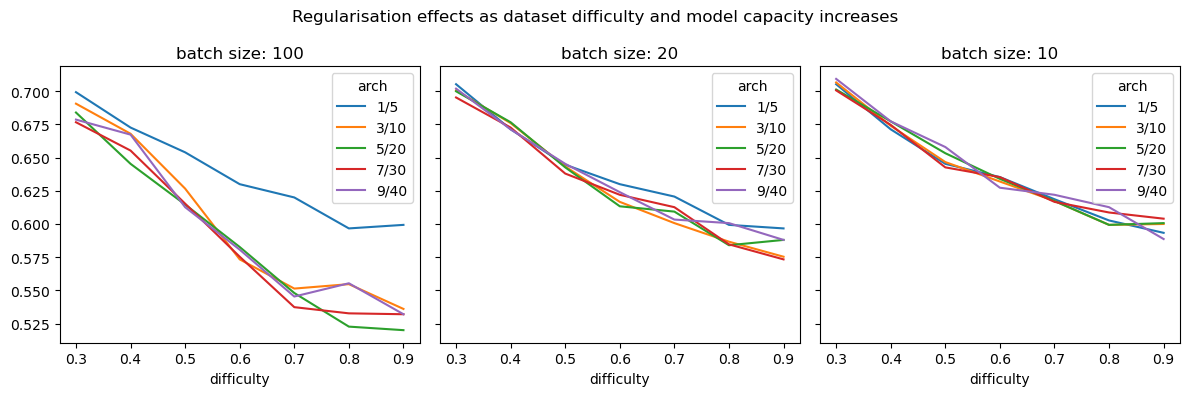

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle(f"Regularisation effects as dataset difficulty and model capacity increases")

res.query("batch_size==100").pivot_table(index="difficulty", columns="arch", values='acc').plot(title="batch size: 100", ax=axes[0])
res.query("batch_size==20").pivot_table(index="difficulty", columns="arch", values='acc').plot(title="batch size: 20", ax=axes[1])
res.query("batch_size==10").pivot_table(index="difficulty", columns="arch", values='acc').plot(title="batch size: 10", ax=axes[2])

plt.tight_layout()
plt.show()